In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
import math

def grayscale(img):
    #Applies the Grayscale transform
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def gaussian_noise(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def region_of_interest(img, vertices):
    #Applies an image mask.

    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    top = 320
    #bottom = 550
    bottom=img.shape[0]
    
    left_x1s = []
    left_y1s = []
    left_x2s = []
    left_y2s = []
    right_x1s = []
    right_y1s = []
    right_x2s = []
    right_y2s = []
    for line in lines:
        #print(line)
        # Feel this is the brute force method, but I'm time constrained. I will research ideal numpy methods later.
        for x1,y1,x2,y2 in line:
            
            slope = get_slope(x1,y1,x2,y2)
            if slope < 0:
                # Ignore obviously invalid lines
                if slope > -.5 or slope < -.8:
                    continue        
                left_x1s.append(x1)
                left_y1s.append(y1)
                left_x2s.append(x2)
                left_y2s.append(y2)
            else:
                # Ignore obviously invalid lines
                if slope < .5 or slope > .8:
                    continue        
                right_x1s.append(x1)
                right_y1s.append(y1)
                right_x2s.append(x2)
                right_y2s.append(y2)
                
    try:
        avg_right_x1 = int(np.mean(right_x1s))
        avg_right_y1 = int(np.mean(right_y1s))
        avg_right_x2 = int(np.mean(right_x2s))
        avg_right_y2 = int(np.mean(right_y2s))
        right_slope = get_slope(avg_right_x1,avg_right_y1,avg_right_x2,avg_right_y2)

        right_y1 = top
        right_x1 = int(avg_right_x1 + (right_y1 - avg_right_y1) / right_slope)
        right_y2 = bottom
        right_x2 = int(avg_right_x1 + (right_y2 - avg_right_y1) / right_slope)
        cv2.line(img, (right_x1, right_y1), (right_x2, right_y2), color, thickness)
    except ValueError:
        # Don't error when a line cannot be drawn
        pass

    try:
        avg_left_x1 = int(np.mean(left_x1s))
        avg_left_y1 = int(np.mean(left_y1s))
        avg_left_x2 = int(np.mean(left_x2s))
        avg_left_y2 = int(np.mean(left_y2s))
        left_slope = get_slope(avg_left_x1,avg_left_y1,avg_left_x2,avg_left_y2)

        left_y1 = top
        left_x1 = int(avg_left_x1 + (left_y1 - avg_left_y1) / left_slope)
        left_y2 = bottom
        left_x2 = int(avg_left_x1 + (left_y2 - avg_left_y1) / left_slope)
        cv2.line(img, (left_x1, left_y1), (left_x2, left_y2), color, thickness)        
    except ValueError:
        # Don't error when a line cannot be drawn
        pass
    
def get_slope(x1,y1,x2,y2):
    return ((y2-y1)/(x2-x1))

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #print(lines)
    # Make a RGB shape of the correct dimensions
    shape = (img.shape[0], img.shape[1], 3)
    line_img = np.zeros(shape, dtype=np.uint8)

    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=.8, β=1., λ=0.):
    #merge output image
    return cv2.addWeighted(initial_img, α, img, β, λ)

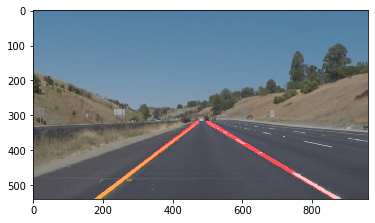

In [2]:
def process_image(image):
    gray = grayscale(image)
    gaus = gaussian_noise(gray, 5)
    edges = canny(gaus, 50,150)    
    imshape = image.shape
    
    vertices = np.array([[(0,imshape[0]),(450, 320), (500, 320), (imshape[1],imshape[0])]], dtype=np.int32)    
    masked = region_of_interest(edges, vertices)
    
    rho = 2            #distance resolution in pixels of the Hough grid
    theta = np.pi/180  #angular resolution in radians of the Hough grid
    threshold = 20     #minimum number of votes (intersections in Hough grid cell)
    min_line_len = 25  #minimum number of pixels making up a line
    max_line_gap = 20  #maximum gap in pixels between connectable line segments
    line_image = hough_lines(masked, rho, theta, threshold, min_line_len, max_line_gap)
    
    result = weighted_img(line_image, image)
    return result

import os
images = os.listdir("find_lines/test_images/")

for img_file in images:
    
    image = mpimg.imread('find_lines/test_images/' + img_file)   
    
    weighted = process_image(image)

    plt.imshow(weighted)
    #break
    mpimg.imsave('find_lines/result_image/result-' + img_file, weighted)

In [3]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#test video
white_output = 'find_lines/result_video/result_solidWhite.mp4'

clip1 = VideoFileClip("find_lines/test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))


t:   9%|▉         | 20/221 [00:00<00:01, 198.99it/s, now=None]

Moviepy - Building video find_lines/result_video/result_solidWhite.mp4.
Moviepy - Writing video find_lines/result_video/result_solidWhite.mp4



Moviepy - Done !
Moviepy - video ready find_lines/result_video/result_solidWhite.mp4
CPU times: user 4.5 s, sys: 155 ms, total: 4.65 s
Wall time: 2.59 s


In [4]:
#test video 2
white_output = 'find_lines/result_video/result_solidYellow.mp4'

clip1 = VideoFileClip("find_lines/test_videos/solidYellowLeft.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))


t:   3%|▎         | 18/681 [00:00<00:03, 174.23it/s, now=None]

Moviepy - Building video find_lines/result_video/result_solidYellow.mp4.
Moviepy - Writing video find_lines/result_video/result_solidYellow.mp4



Moviepy - Done !
Moviepy - video ready find_lines/result_video/result_solidYellow.mp4
CPU times: user 14.8 s, sys: 572 ms, total: 15.3 s
Wall time: 7.9 s


In [5]:
#test challenge video
white_output = 'find_lines/result_video/result_challenge.mp4'

clip1 = VideoFileClip("find_lines/test_videos/challenge.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

t:   4%|▍         | 10/251 [00:00<00:02, 96.94it/s, now=None]

Moviepy - Building video find_lines/result_video/result_challenge.mp4.
Moviepy - Writing video find_lines/result_video/result_challenge.mp4



Moviepy - Done !
Moviepy - video ready find_lines/result_video/result_challenge.mp4
CPU times: user 8.28 s, sys: 417 ms, total: 8.7 s
Wall time: 6.18 s
